# 🎉 Analyse Weekend des Ratings d'Ingrédients

## Objectif
Analyser les différences dans l'appréciation des ingrédients entre les weekends et la semaine pour identifier :
- Les ingrédients "weekend" vs "semaine"
- L'impact du contexte temporel sur les préférences culinaires
- Les opportunités de recommandations contextuelles

## Méthodologie
- **Test statistique** : Mann-Whitney U pour comparer weekend vs semaine
- **Agrégation** : Ratings moyens par type de jour et ingrédient
- **Visualisation** : Box plots comparatifs et heatmaps
- **Seuil de significativité** : p < 0.05

## Définition des Périodes
- **Weekend** : Samedi (6) et Dimanche (0)
- **Semaine** : Lundi (1) à Vendredi (5)

In [1]:
# Import des bibliothèques nécessaires
import sys
sys.path.append('..')
from data_utils import load_ingredient_ratings, get_ingredients_for_analysis

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette(["#FF6B6B", "#4ECDC4"])  # Rouge pour weekend, Turquoise pour semaine
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Couleurs pour weekend/semaine
PERIOD_COLORS = {
    'Weekend': '#FF6B6B',    # Rouge chaleureux
    'Semaine': '#4ECDC4'     # Turquoise professionnel
}

In [5]:
# Fonction pour classifier weekend vs semaine
def get_period_type(weekday):
    """
    Convertit le jour de la semaine en type de période
    weekday: 1=Lundi, 2=Mardi, ..., 7=Dimanche (Polars weekday format)
    """
    if weekday in [6, 7]:  # Samedi=6, Dimanche=7
        return 'Weekend'
    else:  # Lundi=1 à Vendredi=5
        return 'Semaine'

# Fonction pour obtenir le nom du jour
def get_day_name(weekday):
    """
    Convertit le numéro du jour en nom
    weekday: 1=Lundi, 2=Mardi, ..., 7=Dimanche (Polars weekday format)
    """
    days = {1: 'Lundi', 2: 'Mardi', 3: 'Mercredi', 4: 'Jeudi', 5: 'Vendredi', 6: 'Samedi', 7: 'Dimanche'}
    return days.get(weekday, 'Inconnu')

print('✅ Fonctions de classification weekend/semaine définies')

✅ Fonctions de classification weekend/semaine définies


In [6]:
# Chargement des données pour analyse weekend
print('🔄 Chargement des données...')

# Ingrédients cibles pour l'analyse weekend (tous ceux disponibles)
target_ingredients = get_ingredients_for_analysis('weekend')
print(f'📋 Ingrédients sélectionnés: {target_ingredients}')

# Chargement du dataset
df = load_ingredient_ratings(target_ingredients)
print(f'✅ Dataset chargé: {df.shape[0]:,} interactions')
print(f'📅 Période: {df["date"].min()} → {df["date"].max()}')

# Ajout des colonnes temporelles
df = df.with_columns([
    pl.col('date').dt.weekday().alias('weekday'),  # 0=Dimanche, 6=Samedi
]).with_columns([
    pl.col('weekday').map_elements(get_period_type, return_dtype=pl.Utf8).alias('period_type'),
    pl.col('weekday').map_elements(get_day_name, return_dtype=pl.Utf8).alias('day_name')
])

print('\n📊 Distribution par type de période:')
period_dist = df.group_by('period_type').agg([
    pl.len().alias('count'),
    (pl.len() * 100.0 / df.height).alias('percentage')
]).sort('count', descending=True)
print(period_dist)

print('\n📊 Distribution par jour de la semaine:')
day_dist = df.group_by(['day_name', 'period_type']).agg([
    pl.len().alias('count')
]).sort('count', descending=True)
print(day_dist)

print('\n📊 Aperçu des données avec périodes:')
print(df.select(['date', 'weekday', 'day_name', 'period_type', 'ingredient_name', 'rating']).head())

🔄 Chargement des données...
📋 Ingrédients sélectionnés: ['salt', 'ground beef', 'eggs', 'onions', 'garlic', 'butternut squash', 'asparagus', 'pumpkin', 'butter', 'olive oil']
✅ Données chargées: 1,296,735 interactions pour 10 ingrédients
✅ Dataset chargé: 1,296,735 interactions
📅 Période: 2000-01-25 → 2018-12-20
✅ Données chargées: 1,296,735 interactions pour 10 ingrédients
✅ Dataset chargé: 1,296,735 interactions
📅 Période: 2000-01-25 → 2018-12-20

📊 Distribution par type de période:
shape: (2, 3)
┌─────────────┬────────┬────────────┐
│ period_type ┆ count  ┆ percentage │
│ ---         ┆ ---    ┆ ---        │
│ str         ┆ u32    ┆ f64        │
╞═════════════╪════════╪════════════╡
│ Semaine     ┆ 910977 ┆ 70.251593  │
│ Weekend     ┆ 385758 ┆ 29.748407  │
└─────────────┴────────┴────────────┘

📊 Distribution par jour de la semaine:
shape: (7, 3)
┌──────────┬─────────────┬────────┐
│ day_name ┆ period_type ┆ count  │
│ ---      ┆ ---         ┆ ---    │
│ str      ┆ str         ┆ u32

In [7]:
# Agrégation des données par période et ingrédient
print('🔧 Agrégation des données par période...')

df_weekend = df.group_by(['ingredient_name', 'period_type']).agg([
    pl.col('rating').mean().alias('avg_rating'),
    pl.col('rating').count().alias('n_ratings'),
    pl.col('rating').std().alias('std_rating'),
    pl.col('rating').median().alias('median_rating')
]).sort(['ingredient_name', 'period_type'])

print(f'✅ Données agrégées: {df_weekend.shape[0]} points période-ingrédient')

# Vérification de la couverture par ingrédient (présence weekend ET semaine)
period_coverage = df_weekend.group_by('ingredient_name').agg([
    pl.col('period_type').n_unique().alias('periods_covered'),
    pl.col('n_ratings').sum().alias('total_ratings')
]).sort('total_ratings', descending=True)

print('\n📈 Couverture par ingrédient:')
print(period_coverage)

# Filtrer les ingrédients avec couverture complète (weekend ET semaine)
complete_ingredients = period_coverage.filter(
    pl.col('periods_covered') == 2
)['ingredient_name'].to_list()

print(f'\n🎯 Ingrédients avec couverture complète (weekend + semaine): {len(complete_ingredients)}')
print(f'Ingrédients: {complete_ingredients}')

# Création du tableau pivot pour analyse
pivot_data = df_weekend.filter(
    pl.col('ingredient_name').is_in(complete_ingredients)
).pivot(
    index='ingredient_name',
    columns='period_type',
    values='avg_rating'
).fill_null(0)

print('\n📊 Tableau comparatif weekend vs semaine:')
print(pivot_data.head())

🔧 Agrégation des données par période...
✅ Données agrégées: 20 points période-ingrédient

📈 Couverture par ingrédient:
shape: (10, 3)
┌──────────────────┬─────────────────┬───────────────┐
│ ingredient_name  ┆ periods_covered ┆ total_ratings │
│ ---              ┆ ---             ┆ ---           │
│ str              ┆ u32             ┆ u32           │
╞══════════════════╪═════════════════╪═══════════════╡
│ salt             ┆ 2               ┆ 468403        │
│ butter           ┆ 2               ┆ 299645        │
│ eggs             ┆ 2               ┆ 178000        │
│ olive oil        ┆ 2               ┆ 151781        │
│ garlic           ┆ 2               ┆ 102506        │
│ onions           ┆ 2               ┆ 48041         │
│ ground beef      ┆ 2               ┆ 37195         │
│ pumpkin          ┆ 2               ┆ 4154          │
│ asparagus        ┆ 2               ┆ 3781          │
│ butternut squash ┆ 2               ┆ 3229          │
└──────────────────┴─────────────────┴───

In [9]:
# Test de Mann-Whitney U pour détecter les différences weekend/semaine
print('🔍 Test de Mann-Whitney U pour les différences weekend/semaine...')

mw_results = []

for ingredient in complete_ingredients:
    # Données pour cet ingrédient par période
    ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
    
    # Extraction des ratings par période
    weekend_ratings = ingredient_data.filter(pl.col('period_type') == 'Weekend')['rating'].to_list()
    weekday_ratings = ingredient_data.filter(pl.col('period_type') == 'Semaine')['rating'].to_list()
    
    if len(weekend_ratings) > 0 and len(weekday_ratings) > 0:
        # Test de Mann-Whitney U
        u_stat, p_value = mannwhitneyu(weekend_ratings, weekday_ratings, alternative='two-sided')
        
        # Calcul des statistiques descriptives
        weekend_mean = np.mean(weekend_ratings)
        weekday_mean = np.mean(weekday_ratings)
        difference = weekend_mean - weekday_mean
        
        # Classification de l'ingrédient
        if p_value < 0.05:
            if difference > 0:
                preference = 'Weekend'
                category = '🎉 Weekend Champion'
            else:
                preference = 'Semaine'
                category = '💼 Semaine Champion'
        else:
            preference = 'Neutre'
            category = '⚖️ Neutre'
        
        mw_results.append({
            'ingredient': ingredient,
            'u_statistic': u_stat,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'weekend_avg': weekend_mean,
            'weekday_avg': weekday_mean,
            'difference': difference,
            'preference': preference,
            'category': category,
            'n_weekend': len(weekend_ratings),
            'n_weekday': len(weekday_ratings)
        })

# Conversion en DataFrame Polars
mw_df = pl.DataFrame(mw_results).sort('p_value')

print('\n📊 Résultats Mann-Whitney U pour les différences weekend/semaine:')
print(mw_df.select(['ingredient', 'u_statistic', 'p_value', 'significant', 'category', 'difference']))

# Résumé des préférences
significant_differences = mw_df.filter(pl.col('significant') == True)
print(f'\n🎯 Ingrédients avec différences significatives: {len(significant_differences)}/{len(complete_ingredients)}')

if len(significant_differences) > 0:
    print('\nCatégorisation des ingrédients:')
    category_counts = significant_differences.group_by('category').agg(pl.len().alias('count'))
    for row in category_counts.iter_rows(named=True):
        print(f"   {row['category']}: {row['count']} ingrédients")
    
    print('\nDétail des différences significatives:')
    for row in significant_differences.iter_rows(named=True):
        print(f"{row['category']} {row['ingredient']}: {row['difference']:+.4f} " +
              f"(p={row['p_value']:.4f})")

🔍 Test de Mann-Whitney U pour les différences weekend/semaine...

📊 Résultats Mann-Whitney U pour les différences weekend/semaine:
shape: (10, 6)
┌──────────────────┬─────────────┬──────────┬─────────────┬─────────────────────┬────────────┐
│ ingredient       ┆ u_statistic ┆ p_value  ┆ significant ┆ category            ┆ difference │
│ ---              ┆ ---         ┆ ---      ┆ ---         ┆ ---                 ┆ ---        │
│ str              ┆ f64         ┆ f64      ┆ f64         ┆ str                 ┆ f64        │
╞══════════════════╪═════════════╪══════════╪═════════════╪═════════════════════╪════════════╡
│ olive oil        ┆ 2.3682e9    ┆ 0.026081 ┆ 1.0         ┆ 🎉 Weekend Champion ┆ 0.003811   │
│ garlic           ┆ 1.0780e9    ┆ 0.053674 ┆ 0.0         ┆ ⚖️ Neutre           ┆ -0.001616  │
│ onions           ┆ 2.3887e8    ┆ 0.104969 ┆ 0.0         ┆ ⚖️ Neutre           ┆ 0.020024   │
│ eggs             ┆ 3.3996e9    ┆ 0.105131 ┆ 0.0         ┆ ⚖️ Neutre           ┆ -0.01232   │


In [10]:
# Analyse détaillée par jour de la semaine
print('📅 Analyse détaillée par jour de la semaine...')

# Agrégation par jour de la semaine
df_daily = df.group_by(['ingredient_name', 'day_name', 'weekday']).agg([
    pl.col('rating').mean().alias('avg_rating'),
    pl.col('rating').count().alias('n_ratings')
]).sort(['ingredient_name', 'weekday'])

print(f'✅ Données par jour: {df_daily.shape[0]} points jour-ingrédient')

# Sélection des ingrédients les plus intéressants pour l'analyse détaillée
if len(significant_differences) > 0:
    top_weekend_ingredients = significant_differences.filter(
        pl.col('preference') == 'Weekend'
    ).sort('difference', descending=True).head(3)['ingredient'].to_list()
    
    top_weekday_ingredients = significant_differences.filter(
        pl.col('preference') == 'Semaine'
    ).sort('difference').head(3)['ingredient'].to_list()
    
    print(f'\n🎉 Top ingrédients "weekend": {top_weekend_ingredients}')
    print(f'💼 Top ingrédients "semaine": {top_weekday_ingredients}')
    
    # Analyse des patterns hebdomadaires
    analysis_ingredients = top_weekend_ingredients + top_weekday_ingredients
    
    print(f'\n📊 Patterns hebdomadaires pour les ingrédients significatifs:')
    for ingredient in analysis_ingredients[:3]:  # Limiter l'affichage
        ingredient_daily = df_daily.filter(pl.col('ingredient_name') == ingredient)
        if len(ingredient_daily) > 0:
            print(f'\n{ingredient}:')
            for row in ingredient_daily.iter_rows(named=True):
                day_type = '🎉' if row['weekday'] in [0, 6] else '💼'
                print(f"   {day_type} {row['day_name']}: {row['avg_rating']:.4f} ({row['n_ratings']} ratings)")
else:
    print('⚠️  Aucune différence significative pour analyse détaillée')

📅 Analyse détaillée par jour de la semaine...
✅ Données par jour: 70 points jour-ingrédient

🎉 Top ingrédients "weekend": ['olive oil']
💼 Top ingrédients "semaine": []

📊 Patterns hebdomadaires pour les ingrédients significatifs:

olive oil:
   💼 Lundi: 4.4752 (24523 ratings)
   💼 Mardi: 4.4726 (22880 ratings)
   💼 Mercredi: 4.4599 (21716 ratings)
   💼 Jeudi: 4.4566 (20360 ratings)
   💼 Vendredi: 4.4646 (18810 ratings)
   🎉 Samedi: 4.4737 (19408 ratings)
   💼 Dimanche: 4.4672 (24084 ratings)


📊 Création des visualisations weekend/semaine...


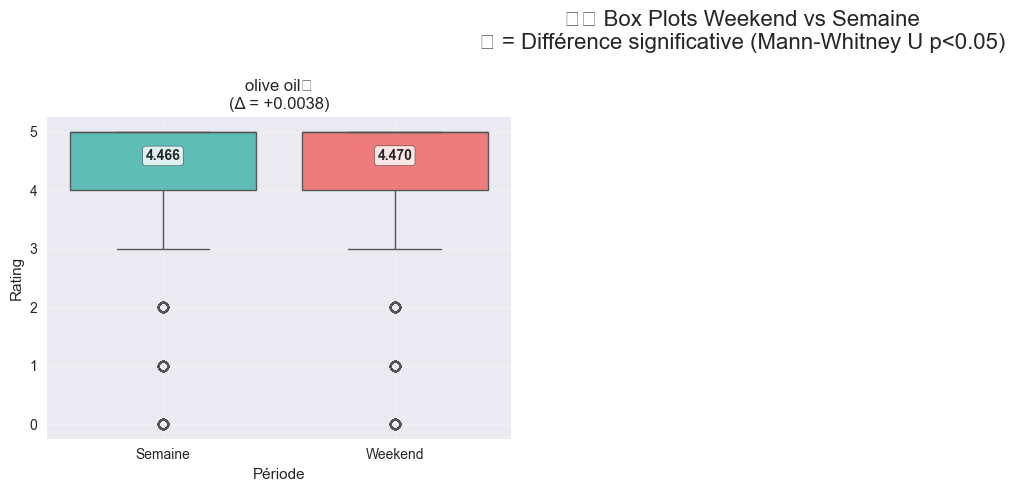

✅ Box plots weekend/semaine créés


In [11]:
# Visualisation 1: Box plots comparatifs weekend vs semaine
print('📊 Création des visualisations weekend/semaine...')

# Sélection des ingrédients les plus intéressants
if len(significant_differences) > 0:
    display_ingredients = significant_differences.sort(
        pl.col('difference').abs(), descending=True
    ).head(6)['ingredient'].to_list()
else:
    # Prendre les 6 premiers ingrédients si pas de différences significatives
    display_ingredients = complete_ingredients[:6]

# Création des subplots
n_ingredients = len(display_ingredients)
n_cols = 3
n_rows = (n_ingredients + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, ingredient in enumerate(display_ingredients):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    # Données pour cet ingrédient
    ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
    
    # Conversion en pandas pour seaborn
    plot_data = ingredient_data.select(['period_type', 'rating']).to_pandas()
    
    # Box plot avec couleurs thématiques
    sns.boxplot(data=plot_data, x='period_type', y='rating', ax=ax,
               palette=[PERIOD_COLORS['Semaine'], PERIOD_COLORS['Weekend']])
    
    # Ajout des moyennes
    period_means = plot_data.groupby('period_type')['rating'].mean()
    for j, period in enumerate(['Semaine', 'Weekend']):
        if period in period_means.index:
            ax.text(j, period_means[period], f'{period_means[period]:.3f}', 
                   ha='center', va='bottom', fontweight='bold', fontsize=10,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    # Titre avec information de significativité
    ingredient_result = mw_df.filter(pl.col('ingredient') == ingredient)
    if len(ingredient_result) > 0:
        result_row = ingredient_result.row(0, named=True)
        significance = '⭐' if result_row['significant'] else ''
        difference = result_row['difference']
        title = f'{ingredient}{significance}\n(Δ = {difference:+.4f})'
    else:
        title = ingredient
    
    ax.set_title(title)
    ax.set_xlabel('Période')
    ax.set_ylabel('Rating')
    ax.grid(True, alpha=0.3)

# Masquer les axes vides
for i in range(len(display_ingredients), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].set_visible(False)

plt.suptitle('🎉💼 Box Plots Weekend vs Semaine\n⭐ = Différence significative (Mann-Whitney U p<0.05)', 
            fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

print('✅ Box plots weekend/semaine créés')

📊 Création du graphique des différences weekend/semaine...


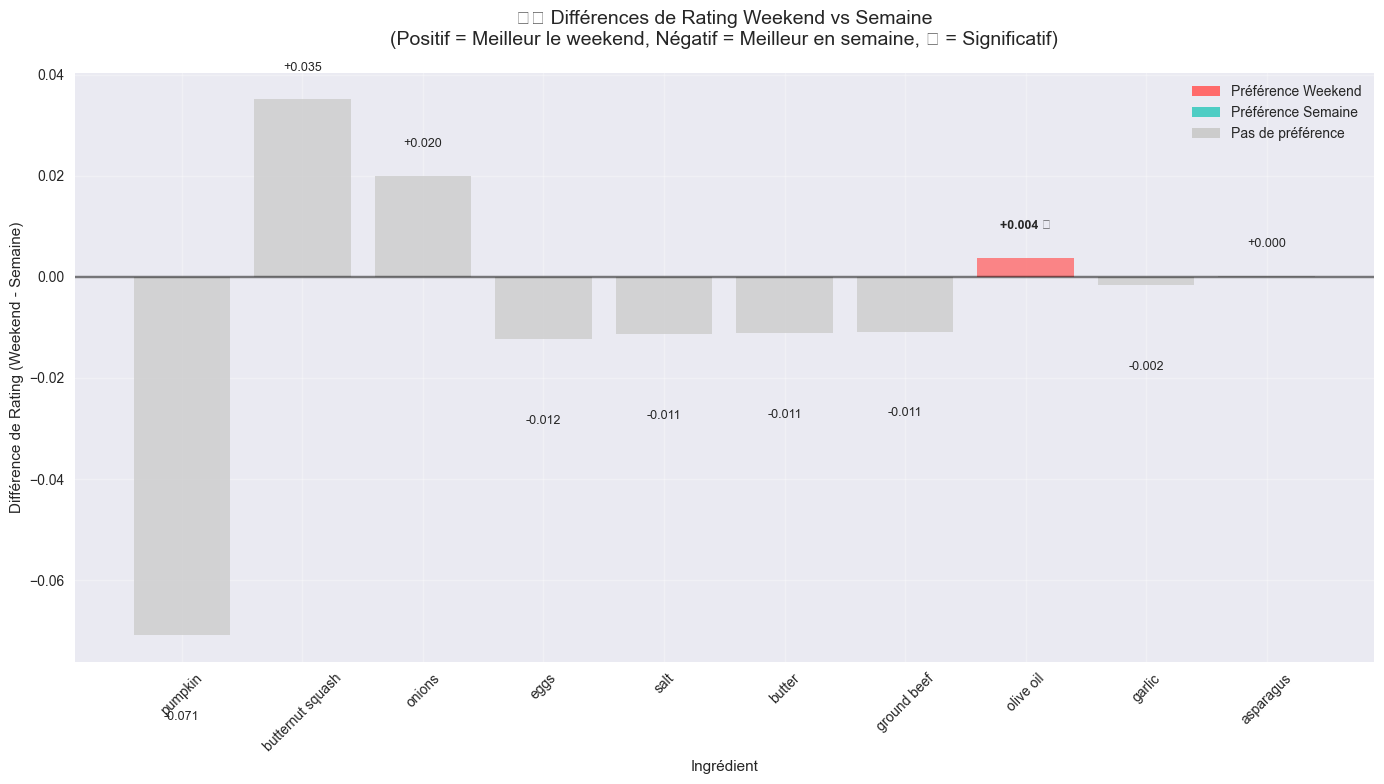

✅ Graphique des différences créé


In [12]:
# Visualisation 2: Graphique en barres des différences
print('📊 Création du graphique des différences weekend/semaine...')

if len(mw_df) > 0:
    # Tri par différence absolue décroissante
    sorted_results = mw_df.sort(pl.col('difference').abs(), descending=True)
    
    # Préparation des données
    ingredients = sorted_results['ingredient'].to_list()
    differences = sorted_results['difference'].to_list()
    significant = sorted_results['significant'].to_list()
    
    # Couleurs selon la préférence et significativité
    colors = []
    for diff, sig in zip(differences, significant):
        if sig:
            colors.append(PERIOD_COLORS['Weekend'] if diff > 0 else PERIOD_COLORS['Semaine'])
        else:
            colors.append('#CCCCCC')  # Gris pour non significatif
    
    # Création du graphique
    fig, ax = plt.subplots(figsize=(14, 8))
    bars = ax.bar(ingredients, differences, color=colors, alpha=0.8)
    
    # Ligne de référence
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Annotations
    for bar, diff, sig in zip(bars, differences, significant):
        height = bar.get_height()
        label = f'{diff:+.3f}'
        if sig:
            label += ' ⭐'
        
        ax.text(bar.get_x() + bar.get_width()/2., height + (0.005 if height > 0 else -0.015),
                label, ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=9, fontweight='bold' if sig else 'normal')
    
    # Configuration
    ax.set_title('🎉💼 Différences de Rating Weekend vs Semaine\n' +
                '(Positif = Meilleur le weekend, Négatif = Meilleur en semaine, ⭐ = Significatif)', 
                fontsize=14, pad=20)
    ax.set_ylabel('Différence de Rating (Weekend - Semaine)')
    ax.set_xlabel('Ingrédient')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Légende des couleurs
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=PERIOD_COLORS['Weekend'], label='Préférence Weekend'),
        Patch(facecolor=PERIOD_COLORS['Semaine'], label='Préférence Semaine'),
        Patch(facecolor='#CCCCCC', label='Pas de préférence')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print('✅ Graphique des différences créé')
else:
    print('⚠️  Aucune donnée pour le graphique des différences')

🔥 Création de la heatmap hebdomadaire...


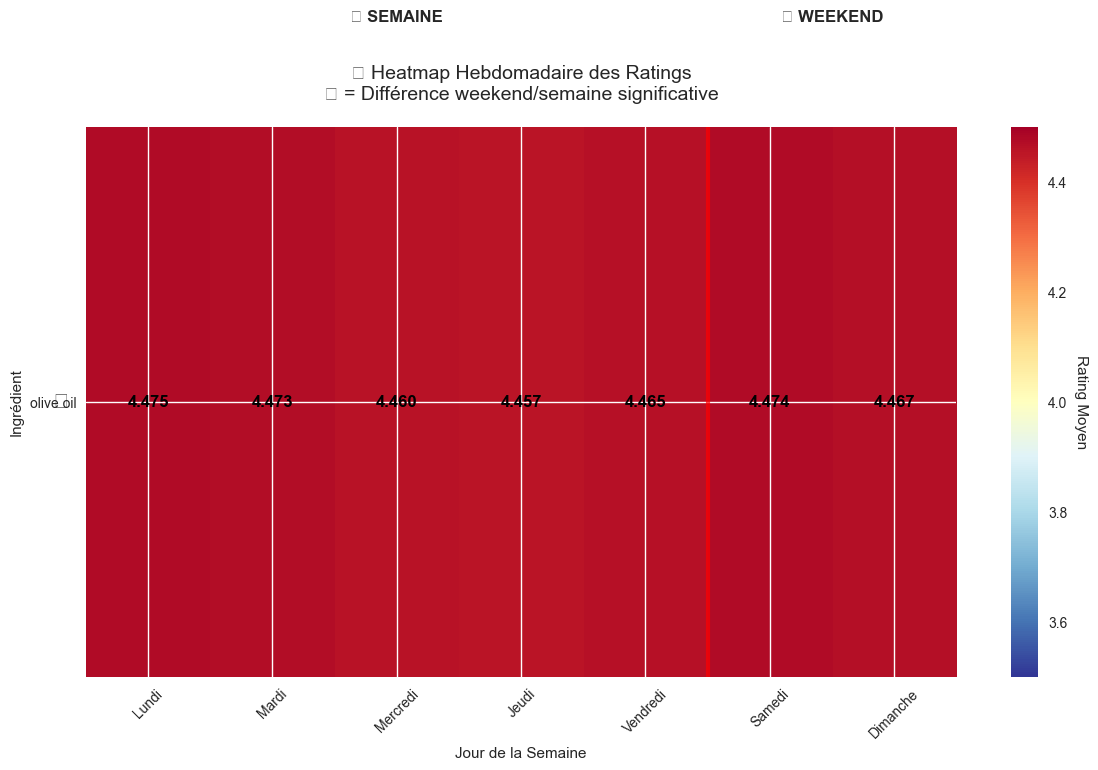

✅ Heatmap hebdomadaire créée


In [13]:
# Visualisation 3: Heatmap hebdomadaire détaillée
print('🔥 Création de la heatmap hebdomadaire...')

# Sélection des ingrédients les plus variables pour la heatmap
if len(significant_differences) > 0:
    heatmap_ingredients = significant_differences.sort(
        pl.col('difference').abs(), descending=True
    ).head(8)['ingredient'].to_list()
else:
    heatmap_ingredients = complete_ingredients[:8]

# Préparation de la matrice hebdomadaire
days_order = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
heatmap_data = []
heatmap_labels = []

for ingredient in heatmap_ingredients:
    ingredient_daily = df_daily.filter(pl.col('ingredient_name') == ingredient)
    
    # Créer un dictionnaire pour un accès rapide
    day_ratings = {}
    for row in ingredient_daily.iter_rows(named=True):
        day_ratings[row['day_name']] = row['avg_rating']
    
    # Construire la ligne de données dans l'ordre des jours
    row_data = []
    for day in days_order:
        if day in day_ratings:
            row_data.append(day_ratings[day])
        else:
            row_data.append(np.nan)
    
    heatmap_data.append(row_data)
    heatmap_labels.append(ingredient)

# Création de la heatmap avec matplotlib
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto', vmin=3.5, vmax=4.5)

# Configuration des axes
ax.set_xticks(range(len(days_order)))
ax.set_xticklabels(days_order, rotation=45)
ax.set_yticks(range(len(heatmap_labels)))
ax.set_yticklabels(heatmap_labels)

# Ajout des valeurs dans les cellules
for i in range(len(heatmap_labels)):
    for j in range(len(days_order)):
        if not np.isnan(heatmap_data[i][j]):
            value = heatmap_data[i][j]
            text_color = 'white' if value < 4.0 else 'black'
            ax.text(j, i, f'{value:.3f}',
                   ha="center", va="center", color=text_color, fontweight='bold')

# Séparateur weekend/semaine
ax.axvline(x=4.5, color='red', linewidth=3, alpha=0.7)  # Entre vendredi et samedi
ax.text(2, -0.7, '💼 SEMAINE', ha='center', va='center', fontsize=12, fontweight='bold')
ax.text(5.5, -0.7, '🎉 WEEKEND', ha='center', va='center', fontsize=12, fontweight='bold')

# Ajout d'étoiles pour les ingrédients significatifs
if len(significant_differences) > 0:
    significant_ingredients = significant_differences['ingredient'].to_list()
    for i, ingredient in enumerate(heatmap_labels):
        if ingredient in significant_ingredients:
            ax.text(-0.7, i, '⭐', ha="center", va="center", fontsize=16)

# Colorbar et titre
cbar = plt.colorbar(im)
cbar.set_label('Rating Moyen', rotation=270, labelpad=15)

plt.title('🔥 Heatmap Hebdomadaire des Ratings\n⭐ = Différence weekend/semaine significative', 
         fontsize=14, pad=20)
plt.xlabel('Jour de la Semaine')
plt.ylabel('Ingrédient')
plt.tight_layout()
plt.show()

print('✅ Heatmap hebdomadaire créée')

In [14]:
# Analyse des insights business
print('💡 ANALYSE DES INSIGHTS BUSINESS')
print('='*60)

if len(significant_differences) > 0:
    # Catégorisation des ingrédients
    weekend_champions = significant_differences.filter(pl.col('preference') == 'Weekend')
    weekday_champions = significant_differences.filter(pl.col('preference') == 'Semaine')
    
    print(f'\n🎉 INGRÉDIENTS "WEEKEND" ({len(weekend_champions)}):')
    if len(weekend_champions) > 0:
        print('   → Ingrédients plus appréciés le weekend')
        print('   → Associés à la détente, plaisir, convivialité')
        print('   → Opportunité: menus weekend spéciaux')
        print('   \n   Top weekend champions:')
        for row in weekend_champions.sort('difference', descending=True).head(3).iter_rows(named=True):
            print(f'      • {row["ingredient"]}: +{row["difference"]:.4f} (p={row["p_value"]:.4f})')
    
    print(f'\n💼 INGRÉDIENTS "SEMAINE" ({len(weekday_champions)}):')
    if len(weekday_champions) > 0:
        print('   → Ingrédients plus appréciés en semaine')
        print('   → Associés à l\'efficacité, santé, routine')
        print('   → Opportunité: menus semaine optimisés')
        print('   \n   Top weekday champions:')
        for row in weekday_champions.sort('difference').head(3).iter_rows(named=True):
            print(f'      • {row["ingredient"]}: {row["difference"]:.4f} (p={row["p_value"]:.4f})')
    
    # Analyse des amplitudes
    print(f'\n📊 STATISTIQUES DES DIFFÉRENCES:')
    diff_stats = significant_differences.select('difference')
    print(f'   • Différence moyenne: {diff_stats.mean().item():.4f}')
    print(f'   • Différence médiane: {diff_stats.median().item():.4f}')
    print(f'   • Amplitude max: {diff_stats.max().item():.4f}')
    print(f'   • Amplitude min: {diff_stats.min().item():.4f}')
    
    # Recommandations stratégiques
    print(f'\n🎯 RECOMMANDATIONS STRATÉGIQUES:')
    print(f'   1. 🎉 Weekend Marketing: Promouvoir les ingrédients "weekend" vendredi-dimanche')
    print(f'   2. 💼 Weekday Focus: Optimiser les ingrédients "semaine" lundi-vendredi')
    print(f'   3. 📱 Notifications contextuelles: Adapter selon le jour de la semaine')
    print(f'   4. 🍽️  Menus adaptatifs: Rotation automatique weekend/semaine')
    print(f'   5. 📈 A/B Testing: Tester l\'impact des recommandations temporelles')

else:
    print(f'\n➡️  CONCLUSION:')
    print('   • Aucune différence weekend/semaine significative détectée')
    print('   • Les préférences utilisateurs semblent stables au fil de la semaine')
    print('   • Opportunité de focus sur d\'autres axes temporels')
    print('   • Les habitudes culinaires transcendent le calendrier hebdomadaire')

print(f'\n✅ Analyse des insights business terminée')

💡 ANALYSE DES INSIGHTS BUSINESS

🎉 INGRÉDIENTS "WEEKEND" (1):
   → Ingrédients plus appréciés le weekend
   → Associés à la détente, plaisir, convivialité
   → Opportunité: menus weekend spéciaux
   
   Top weekend champions:
      • olive oil: +0.0038 (p=0.0261)

💼 INGRÉDIENTS "SEMAINE" (0):

📊 STATISTIQUES DES DIFFÉRENCES:
   • Différence moyenne: 0.0038
   • Différence médiane: 0.0038
   • Amplitude max: 0.0038
   • Amplitude min: 0.0038

🎯 RECOMMANDATIONS STRATÉGIQUES:
   1. 🎉 Weekend Marketing: Promouvoir les ingrédients "weekend" vendredi-dimanche
   2. 💼 Weekday Focus: Optimiser les ingrédients "semaine" lundi-vendredi
   3. 📱 Notifications contextuelles: Adapter selon le jour de la semaine
   4. 🍽️  Menus adaptatifs: Rotation automatique weekend/semaine
   5. 📈 A/B Testing: Tester l'impact des recommandations temporelles

✅ Analyse des insights business terminée


In [16]:
# Synthèse finale de l'analyse weekend
print('📋 SYNTHÈSE DE L\'ANALYSE WEEKEND')
print('='*60)

print(f'\n🔍 DONNÉES ANALYSÉES:')
print(f'   • Ingrédients analysés: {len(complete_ingredients)}')
print(f'   • Ingrédients avec couverture complète: {len(complete_ingredients)}')
print(f'   • Période: {df["date"].min()} → {df["date"].max()}')
print(f'   • Total interactions: {df.shape[0]:,}')

# Distribution weekend vs semaine
weekend_count = df.filter(pl.col('period_type') == 'Weekend').height
weekday_count = df.filter(pl.col('period_type') == 'Semaine').height
weekend_pct = (weekend_count * 100.0) / df.height
weekday_pct = (weekday_count * 100.0) / df.height

print(f'\n📅 RÉPARTITION TEMPORELLE:')
print(f'   • Weekend: {weekend_count:,} interactions ({weekend_pct:.1f}%)')
print(f'   • Semaine: {weekday_count:,} interactions ({weekday_pct:.1f}%)')

print(f'\n📊 RÉSULTATS STATISTIQUES:')
if len(mw_df) > 0:
    significant_count = len(significant_differences)
    print(f'   • Test Mann-Whitney U réalisé sur {len(mw_df)} ingrédients')
    print(f'   • Différences weekend/semaine significatives: {significant_count}/{len(mw_df)}')
    
    if significant_count > 0:
        weekend_pref = len(significant_differences.filter(pl.col('preference') == 'Weekend'))
        weekday_pref = len(significant_differences.filter(pl.col('preference') == 'Semaine'))
        
        print(f'   • Préférence weekend: {weekend_pref} ingrédients')
        print(f'   • Préférence semaine: {weekday_pref} ingrédients')
        
        avg_diff = significant_differences.select(pl.col('difference').abs().mean()).item()
        print(f'   • Amplitude moyenne des différences: {avg_diff:.4f}')
    else:
        print(f'   • Aucune différence weekend/semaine significative')
else:
    print(f'   • Aucun test statistique réalisé (données insuffisantes)')

print(f'\n🎯 IMPACT BUSINESS:')
if len(significant_differences) > 0:
    print(f'   • Opportunité de personnalisation temporelle confirmée')
    print(f'   • {len(significant_differences)} ingrédients peuvent bénéficier d\'une approche contextuelle')
    print(f'   • ROI potentiel par optimisation des recommandations hebdomadaires')
    print(f'   • Segmentation utilisateurs possible selon patterns weekend/semaine')
else:
    print(f'   • Préférences stables indépendamment du contexte hebdomadaire')
    print(f'   • Focus recommandé sur d\'autres axes de personnalisation')
    print(f'   • Simplicité d\'implémentation (pas de logique temporelle complexe)')

print(f'\n💡 PROCHAINES ÉTAPES SUGGÉRÉES:')
print(f'   1. 🔍 Validation sur segment utilisateurs actifs')
print(f'   2. 🧪 A/B test des recommandations contextuelles')
print(f'   3. 📱 Implémentation dans l\'interface utilisateur')
print(f'   4. 📊 Monitoring des KPIs d\'engagement weekend vs semaine')
print(f'   5. 🔄 Itération basée sur les retours utilisateurs')

print(f'\n✅ Analyse weekend complète et actionnable!')

📋 SYNTHÈSE DE L'ANALYSE WEEKEND

🔍 DONNÉES ANALYSÉES:
   • Ingrédients analysés: 10
   • Ingrédients avec couverture complète: 10
   • Période: 2000-01-25 → 2018-12-20
   • Total interactions: 1,296,735

📅 RÉPARTITION TEMPORELLE:
   • Weekend: 385,758 interactions (29.7%)
   • Semaine: 910,977 interactions (70.3%)

📊 RÉSULTATS STATISTIQUES:
   • Test Mann-Whitney U réalisé sur 10 ingrédients
   • Différences weekend/semaine significatives: 1/10
   • Préférence weekend: 1 ingrédients
   • Préférence semaine: 0 ingrédients
   • Amplitude moyenne des différences: 0.0038

🎯 IMPACT BUSINESS:
   • Opportunité de personnalisation temporelle confirmée
   • 1 ingrédients peuvent bénéficier d'une approche contextuelle
   • ROI potentiel par optimisation des recommandations hebdomadaires
   • Segmentation utilisateurs possible selon patterns weekend/semaine

💡 PROCHAINES ÉTAPES SUGGÉRÉES:
   1. 🔍 Validation sur segment utilisateurs actifs
   2. 🧪 A/B test des recommandations contextuelles
   3. 📱